# Tuning an XGBoost Model

The goal of this notebook is to train and evaluate an XGBoost model, comparing it's performance on a holdout set against other types of models (LR, SVC, LDA). 

To ensure reproducibility and consistent evaluation across models, all datasets were **pre-split into cross-val data and holdout data** as below:

| Split type           | CV training file     | Holdout file              | Description                              |
| -------------------- | -------------------- | ------------------------- | ---------------------------------------- |
| **Random**           | `apps_cv_random.csv` | `apps_holdout_random.csv` | Simple random sampling                   |
| **Stratified**       | `apps_cv_strat.csv`  | `apps_holdout_strat.csv`  | Stratified by `TARGET`                   |
| **Multi-Stratified** | `apps_cv_multi.csv`  | `apps_holdout_multi.csv`  | Stratified by `TARGET` + `CODE_GENDER_M` |

Each dataset for cross-validation (`apps_cv_*.csv`) also contains a column, `fold`, with pre-assigned folds from 1-5 using the corresponding splitting method to ensure consistent evaluation. Therefore, no additional splitting is needed inside this notebook -- can simply loop through assigned folds for cross-validation.


In [237]:
import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier
import xgboost as xgb
from itertools import product
import time

## Evaluation Functions

#### Metric calculators:

Copied from `cross_val.ipynb`

In [150]:
# METRICS 

def classification_metrics(y_true, y_pred):
    """
    Computes confusion matrix + accuracy, precision, recall, F1, and balanced accuracy.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Confusion matrix components
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Metrics
    acc  = (tp + tn) / max((tp + tn + fp + fn), 1)
    prec = tp / max((tp + fp), 1)
    rec  = tp / max((tp + fn), 1)
    f1   = (2 * prec * rec / max((prec + rec), 1e-12)) if (prec + rec) > 0 else 0.0

    # Specificity (True Negative Rate)
    spec = tn / max((tn + fp), 1)

    # Balanced accuracy
    bal_acc = 0.5 * (rec + spec)

    metrics = {
        "n": len(y_true),
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "acc": acc, "bal_acc": bal_acc, "prec": prec, "rec": rec, "spec": spec,
        "f1": f1
    }
    return metrics

def roc_auc_from_probs(y_true, y_prob):
    
    desc_sort_indices = np.argsort(-y_prob)
    y_true = np.array(y_true)[desc_sort_indices]
    y_prob = np.array(y_prob)[desc_sort_indices]
    pos = np.sum(y_true == 1)
    neg = np.sum(y_true == 0)

    # running totals for TPR/FPR
    tpr = [0.0]
    fpr = [0.0]
    tp = fp = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / pos)
        fpr.append(fp / neg)

    # get auc
    auc = np.trapz(tpr, fpr)
    return auc

#### Cross-validation function

Note that in `cross_val.ipynb`, we assigned folds already for each type of splitting to maintain consistent comparison across modeling. So, there will be no explicit splitting in this file, we will just use the folds already created according to the type of split we want to use.

Also, while we will be tuning many xgboost parameters, some we will be set consistently for reproducability. These include:

- eval_metric='auc' : tells xgboost to evaluate performance based on ROC-AUC
- random_state=42 : due to random subsampling in tree building, we fix the random seed to get the same results every run
- n_jobs=-1 : uses all available CPU cores in parallel to speed up training
- tree_method='hist' : a histogram-based algorithm provided by xgboost that can be faster than the default exact method with similar performance
- scale_pos_weight = neg/pos : corrects for class imbalance by upweighting minority class so the model focuses more on them in training. we may change this ratio throughout testing, but it won't be a part of grid searches

In [151]:
def cv_xgb(data, feature_cols, target_col, params=None):
    
    if params == None:
        params = {}

    fold_metrics = []
    fold_preds = []
    for f in data.fold.unique():

        # split into train and test based on folds
        train = data[data.fold != f]
        test = data[data.fold == f]
        X_train, y_train = train[feature_cols], train[target_col]
        X_test, y_test = test[feature_cols], test[target_col]

        # calculate counts for class weighting
        pos = (y_train == 1).sum()
        neg = (y_train == 0).sum()
        balanced_weight = (neg / max(pos, 1)) * 0.5

        # fit model with specified params
        model = XGBClassifier(eval_metric='auc', 
                              random_state=42, 
                              n_jobs=-1, 
                              tree_method='hist',
                              scale_pos_weight=balanced_weight,
                              **params
                            )
        model.fit(X_train, y_train)
        
        # get predictions (probablities and decisions)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_train_prob = model.predict_proba(X_train)[:,1] # make training predictions as well to assess overfit
        y_pred = (y_prob >= 0.5).astype(int)

        # calculate classification metrics from previously defined functions
        metrics = classification_metrics(y_test, y_pred)
        metrics['roc_auc'] = roc_auc_from_probs(y_test, y_prob)
        metrics['train_roc_auc'] = roc_auc_from_probs(y_train, y_train_prob)
        metrics['fold'] = int(f)

        # add to list of all fold metrics
        fold_metrics.append(metrics)

        # store raw fold predictions for later threshold tuning
        fold_preds.append(pd.DataFrame({
            "fold": f,
            "y_true": y_test.values,
            "y_prob": y_prob
        }))

    # combine fold predictions into one long DataFrame
    preds_df = pd.concat(fold_preds, ignore_index=True)

    # summary DataFrame for quick metrics view
    metrics_df = pd.DataFrame(fold_metrics).sort_values("fold").reset_index(drop=True)

    # return results in dataframe
    return metrics_df, preds_df

#### A grid-search function:

Tests every combination of hyperparameters -- very slow/inefficient, so consider size of grid.

In [152]:
def grid_search_xgb(data, feature_cols, target_col, param_grid):
    
    # get all possible combinations of parameters
    keys = list(param_grid.keys())
    combos = [dict(zip(keys, v)) for v in product(*param_grid.values())]

    # initialize stuff for tracking and results
    results = []
    total = len(combos)
    start = time.time()
    next_checkpoint = 5 
    best_roc_auc = 0
    best_params = None

    # evaluate every possible combo
    for i, params in enumerate(combos, 1):

        # run cross validation and store results
        metrics, preds = cv_xgb(data, feature_cols, target_col, params)
        mean_roc_auc = metrics["roc_auc"].mean()

        results.append({
            'params': params,
            'mean_roc_auc': mean_roc_auc,
            'mean_f1': metrics['f1'].mean(),
            'mean_acc': metrics['acc'].mean(),
            'mean_bal_acc': metrics['bal_acc'].mean(),
            'mean_prec': metrics['prec'].mean(),
            'mean_rec': metrics['rec'].mean(),
        })

        # tracker for updates
        if  mean_roc_auc > best_roc_auc:
            best_roc_auc =  mean_roc_auc
            best_params = params

        # print progress checkpoints
        pct_done = (i/total)*100
        elapsed = time.time() - start
        if pct_done >= next_checkpoint or i == total:
            print(f"{i}/{total} ({pct_done:5.1f}% in {elapsed/60:.1f} mins) | Best ROC-AUC: {best_roc_auc:.4f} | Best Params: {best_params}")
            next_checkpoint += 5


    
    return pd.DataFrame(results).sort_values("mean_roc_auc", ascending=False).reset_index(drop=True)

# Model Development

**Notes:** 
- All evaluation will focus on stratified cross-validation, but we will test the other methods as well. 
- Recall that folds have been pre-assigned to ensure consistency across different model development processes
- For our other models, we have decided to scale + PCA, but this is not necessary for nonlinear tree-based algorithms like XGBoost
    - these can only really hurt XGBoost, so we will not use it here

**Process:**
1. Setting a baseline
    - evaluating an xgb model with all default parameters to build off of
2. Hyperparameter tuning
    - evaluate many different combinations of parameters
    - choose the best set based on average ROC-AUC across all folds
3. Holdout evaluation
    - evaluate on the corresponding holdout table. the performance here is what we will compare with other models (LR, SVC, LDA)
4. Threshold tuning
    - tweak the threshold on the best model to maximize another chosen metric (recall, precision, f1, balanced accuracy, etc.) 
        - note that roc-auc is not affected by threshold, hence the need a different optimizing metric
    - what metric we choose to optimize with threshold depends on business needs
        - consider the cost of mislabeling someone as high risk? or trusting an applicant that you shouldn't? will there be human review?
        - something we can include in the right up as optionality moving forward, not something we have to decide now on our own
        - "our model is very solid at ranking applicants from low-risk to high-risk, but in terms of actual classification, we can move the threshold based on what matters most to the business"
5. Fairness evaluation

## 0. Setup

Recall that we have different datasets for each type of cross validation. We are currently focusing on the stratified splitting method, but random and multiple-stratification methods are avaiable for testing/comparison.

In [157]:
apps_cv_strat = pd.read_csv("data/apps_cv_strat.csv")
apps_holdout_strat = pd.read_csv("data/apps_holdout_strat.csv")
target_col = 'TARGET'
feature_cols = [col for col in apps_cv_strat.columns if col not in 
                [target_col, 'SK_ID_CURR', 'fold', 'neighbors_target_mean_500', 'AGE_INT', 'CODE_GENDER_M',
                 'CODE_GENDER_XNA', 'DAYS_BIRTH',
                 'NAME_FAMILY_STATUS_Previously Married', 'NAME_FAMILY_STATUS_Single']]

Even though we aren't doing PCA and xgboost handles correlated/unecessary features well, we can still simply our model a bit by removing some of them. It may help us run faster and assess feature importance at the end. This may or may not be used depending on results, but I'll make the set now to keep as an option.

In [6]:
corr = apps_cv_strat[feature_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop)} highly correlated features")

feature_cols_pruned = [f for f in feature_cols if f not in to_drop]

Dropping 35 highly correlated features


## 1. Setting a Baseline

Fitting an XGBoost model with default parameters to understand baseline predictive power and what we can build on.

In [158]:
baseline_metrics, baseline_preds = cv_xgb(apps_cv_strat, feature_cols, target_col, params=None) # send no parameters
baseline_metrics

,n,tp,tn,fp,fn,acc,bal_acc,prec,rec,spec,f1,roc_auc,train_roc_auc,fold
0,49156,1603,40700,4487,2366,0.860587,0.652291,0.263218,0.403880,0.900702,0.318720,0.767795,0.906028,1
1,49156,1621,40578,4609,2348,0.858471,0.653208,0.260193,0.408415,0.898002,0.317874,0.766144,0.903025,2
2,49156,1523,40422,4765,2446,0.853304,0.639137,0.242207,0.383724,0.894549,0.296968,0.749658,0.903107,3
3,49155,1563,40575,4611,2406,0.857247,0.645879,0.253158,0.393802,0.897955,0.308193,0.762121,0.905266,4
4,49154,1597,40603,4583,2371,0.858526,0.650522,0.258414,0.402470,0.898575,0.314742,0.759541,0.904998,5


I will do the same thing for the other CV  methods now -- random split and multi-stratified:

In [235]:
apps_cv_random = pd.read_csv("data/apps_cv_random.csv")
baseline_metrics_random, baseline_preds_random = cv_xgb(apps_cv_random, feature_cols, target_col, params=None) # send no parameters
baseline_metrics_random

,n,tp,tn,fp,fn,acc,bal_acc,prec,rec,spec,f1,roc_auc,train_roc_auc,fold
0,49156,1634,40650,4528,2344,0.860200,0.655267,0.265174,0.410759,0.899774,0.322288,0.766016,0.902249,1
1,49155,1634,40612,4603,2306,0.859445,0.656459,0.261985,0.414721,0.898198,0.321116,0.767464,0.904901,2
2,49155,1572,40573,4699,2311,0.857390,0.650523,0.250678,0.404842,0.896205,0.309632,0.762355,0.904397,3
3,49155,1561,40573,4625,2396,0.857166,0.646082,0.252344,0.394491,0.897672,0.307798,0.766028,0.905429,4
4,49155,1605,40559,4576,2415,0.857776,0.648934,0.259667,0.399254,0.898615,0.314675,0.761159,0.903958,5


In [236]:
apps_cv_multi = pd.read_csv("data/apps_cv_multi.csv")
baseline_metrics_multi, baseline_preds_multi = cv_xgb(apps_cv_multi, feature_cols, target_col, params=None) # send no parameters
baseline_metrics_multi

,n,tp,tn,fp,fn,acc,bal_acc,prec,rec,spec,f1,roc_auc,train_roc_auc,fold
0,49158,1587,40581,4607,2383,0.857805,0.648898,0.256216,0.399748,0.898048,0.312279,0.762606,0.903024,1
1,49157,1586,40540,4647,2384,0.856968,0.648328,0.254452,0.399496,0.897161,0.310889,0.759056,0.901291,2
2,49155,1634,40528,4659,2334,0.857736,0.654345,0.259654,0.411794,0.896895,0.318487,0.770930,0.900757,3
3,49154,1547,40547,4639,2421,0.856370,0.643602,0.250081,0.389869,0.897335,0.304708,0.759214,0.905768,4
4,49154,1597,40440,4746,2371,0.855210,0.648719,0.251774,0.402470,0.894967,0.309766,0.763051,0.905649,5


We pretty much see the same results for a baseline model across all methods of cross-validation. For tuning, we will continue with the single stratified method because it best directly addresses class imbalance issues that may arise later, even though we don't see much differences now.

As for actual metrics: pecision, recall, and F1 are all quite low, while ROC-AUC is relatively strong. This indicates that the model is doing a good job ranking applicants from low-risk to high-risk, as in assigning higher probabilities to true positives, but the actual 0/1 decisions at the default threshold of 0.5 are poor (likely due to class imbalance). Also, the training ROC-AUC is even higher than the baseline ROC-AUC indicating some overfit risk. 

Therefore, we expect significant improvement after threshold tuning at the end. This is also why we focus on ROC-AUC during hyperparameter tuning -- as long as the model’s ability to rank cases is good (high ROC-AUC), we can later adjust the threshold to manipulate precision/recall/F1.

## 2. Hyperparameter Tuning

Now, finding hyperparameters that maximize ROC-AUC (while keeping an eye on other metrics). 

XGBoost has a lot of parameters, many of which make a big impact on predictions, so the method of selecting the best ones is more complicated than the other linear models. A simple grid search over a huge parameter grid will take forever, considering just one cross-validated iteration of the baseline model took 15+ seconds. 

Therefore, a smart approach may be to do a multi-step grid search. There are two ways we could do this:

1. Tree structure --> learning dynamics
    - first a grid search on parameters that affect the shape of the trees essentially (max_depth, subsample, etc.)
    - then a grid search on paramaters that affect how the model learns (learning_rate, estimators, etc.)
2. Wide range, big step size --> small range, small step size
    - a grid search on *all* parameters with a very wide range for each parameter
    - then a more granular search on the best parameters to find exact optimal values

We will start with the first structural approach, but then may incorporate the second approach at some points as well. 

### First Pass:

Optimizing tree structure.

In [32]:
param_grid = {

    # fix learning dynamics this pass
    "learning_rate": [0.05], # low learning rate at first to establish reliable tree structure
    "n_estimators": [500], 

    # tree structure parameters to test
    "max_depth": [3, 4, 5, 6, 7],
    "min_child_weight": [1, 3, 5, 8, 12],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0]
}

search1_results = grid_search_xgb(apps_cv_strat, feature_cols, target_col, param_grid)

12/225 (  5.3% in 7.5 mins) | Best ROC-AUC: 0.7790 | Best Params: {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.85}
23/225 ( 10.2% in 14.7 mins) | Best ROC-AUC: 0.7790 | Best Params: {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.85}
34/225 ( 15.1% in 21.5 mins) | Best ROC-AUC: 0.7791 | Best Params: {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 0.85}
45/225 ( 20.0% in 27.5 mins) | Best ROC-AUC: 0.7791 | Best Params: {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 12, 'subsample': 0.7, 'colsample_bytree': 0.85}
57/225 ( 25.3% in 34.6 mins) | Best ROC-AUC: 0.7810 | Best Params: {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 0.7}
68/225 ( 30.2% in 41.3 min

In [34]:
# save so we dont have to run it all again
search1_results.to_csv('results/xgb_search1_results.csv')

In [47]:
search1_results.sort_values(by='mean_roc_auc', ascending=False)[
    ['params', 'mean_roc_auc', 'mean_prec', 'mean_rec', 'mean_f1']].head(10)

,params,mean_roc_auc,mean_prec,mean_rec,mean_f1
0,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781358,0.184567,0.685850,0.290855
1,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781235,0.192193,0.661913,0.297880
2,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781106,0.184413,0.684237,0.290517
3,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781089,0.184827,0.684439,0.291051
4,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781088,0.192360,0.661510,0.298040
5,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781088,0.184615,0.684943,0.290832
6,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781080,0.184300,0.686051,0.290543
7,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781050,0.191841,0.664533,0.297723
8,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781029,0.184236,0.683632,0.290245
9,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.781008,0.184761,0.684539,0.290977


It looks like we found decent lift (+0.02 ROC-AUC) from tuning the tree structure. We also virtually identical scores at the top, not just one outlier, which is a good sign we found an optimal structure -- if these top scores had similar parameters, that would be further proof:

In [58]:
params_df = search1_results['params'].apply(pd.Series)
results = pd.concat([search1_results.drop(columns='params'), params_df], axis=1)
results.sort_values(by='mean_roc_auc', ascending=False)[
    ['mean_roc_auc', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree']].head()

,mean_roc_auc,max_depth,min_child_weight,subsample,colsample_bytree
0,0.781358,4.0,8.0,0.70,0.7
1,0.781235,5.0,8.0,0.85,1.0
2,0.781106,4.0,12.0,0.70,1.0
3,0.781089,4.0,12.0,0.85,1.0
4,0.781088,5.0,8.0,0.70,1.0


The top 5 models by ROC-AUC have very small changes in parameters -- The optimal region occurs with moderate `depth` (4–5), high `min_child_weight` (8–12), and subsampling between 0.7–0.85, suggesting strong generalization, reproducability, and minimal overfitting risk. We also don't see any sitting on a single edge, like if all the best performers were at the highest depth, so there is no reason to believe we are missing anything beyond our grid. 

These parameters will be fixed while tuning learning dynamics in the next phase:

- max_depth = 4
- min_child_weight = 8
- subsample = 0.7
- colsample_bytree = 1

These were the parameters of the best model by ROC-AUC, *except* for `colsample_bytree` because four out of the top five models had this parameter set to 1, so I felt it was safest to keep it as that, even though the #1 model was 0.7.

### Second Pass: Learning Dynamics

Now that we have a reliable tree structure, we will focus on the parameters that effect how the model learns. 

I think in this case it makes more sense to do the wide-then-narrow search approach because the learning parameters are continuous and small changes can make a big difference. Therefore, we will first find the appropriate scale of each parameter, and then do a narrow search over a smaller range to find more exact optimal parameters. Also, the difference from the best to 2nd (or even 5th) best is so small it's negligble.

**Finding Scale of Learning Dynamics:**

Bigger grid than before, so will take much longer. A reasonable option is to make 'reasonable' learning_rate + n_estimator pairings -- low learnings rates are very likely to underfit with a low number of estimators (trees) because it can't converge fast enough, so you can consider not running some of pairings you think are 'unreasonable'. 

However, I'm going to run this overnight either way and hopefully won't need to run again, so why not be thorough with the full grid. 

In [59]:
param_grid = {

    # fix tree structure to optimal parameters found in pass 1
    "max_depth": [4],
    "min_child_weight": [8],
    "subsample": [0.7],
    "colsample_bytree": [1],

    # wide grid to find scale of learning dynamics
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.10],
    "n_estimators": [300, 500, 800, 1200],
    "gamma": [0.0, 0.1, 0.2, 0.3],
    "reg_alpha": [0.0, 0.5, 1.0],
    "reg_lambda": [1.0, 2.0, 5.0]
}

search2_results = grid_search_xgb(apps_cv_strat, feature_cols, target_col, param_grid)

36/720 (  5.0% in 20.0 mins) | Best ROC-AUC: 0.7565 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}
72/720 ( 10.0% in 46.7 mins) | Best ROC-AUC: 0.7660 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 500, 'gamma': 0.0, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
108/720 ( 15.0% in 82.6 mins) | Best ROC-AUC: 0.7727 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 800, 'gamma': 0.3, 'reg_alpha': 0.5, 'reg_lambda': 1.0}
144/720 ( 20.0% in 134.2 mins) | Best ROC-AUC: 0.7772 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 1200, 'gamma': 0.0, 'reg_alpha': 0.5, 'reg_lambda': 5.0}
180/720 ( 25.0% in 149.6

In [60]:
# save so we dont have to run it all again
search2_results.to_csv('results/xgb_search2_results.csv')

In [61]:
params_df = search2_results['params'].apply(pd.Series)
results = pd.concat([search2_results.drop(columns='params'), params_df], axis=1)
results.sort_values(by='mean_roc_auc', ascending=False)[
    ['mean_roc_auc', 'learning_rate', 'n_estimators', 'gamma', 'reg_alpha', 'reg_lambda']].head(10)

,mean_roc_auc,learning_rate,n_estimators,gamma,reg_alpha,reg_lambda
0,0.783057,0.03,1200.0,0.0,0.5,5.0
1,0.782981,0.03,1200.0,0.3,0.5,5.0
2,0.782968,0.03,1200.0,0.1,0.5,5.0
3,0.782923,0.03,1200.0,0.2,0.5,5.0
4,0.782863,0.05,800.0,0.1,0.0,5.0
5,0.782842,0.03,1200.0,0.2,0.5,1.0
6,0.782842,0.05,800.0,0.0,0.0,5.0
7,0.782786,0.03,1200.0,0.3,0.5,1.0
8,0.782783,0.05,800.0,0.2,0.0,5.0
9,0.782778,0.05,800.0,0.3,0.0,5.0


We see some lift again (+0.002) ROC-AUC, but much smaller than the last pass, which is expected, as we were just hoping to squeeze out points at this stage. Additionally, since all of the top scorers have almost identical performance, we can assume we are close to optimal learning dynamics.

However, I notice that `n_estimators` and `reg_lambda` are consistently on an edge of our parameter range, so before doing our narrow search, I want to expand the scale of these a bit to see if they continue to operate better at higher scale. Also, `gamma` does not seem to have an optimal value at all, so I'll test a wider range for that as well, but suspecting it may not have a real impact on our trees. 

Note that increasing `n_estimators` has the biggest impact on speed, so that is something to consider if speed is required for this model -- but for now, we are just looking for best performance.

In [62]:
param_grid = {

    # fix tree structure to optimal parameters found in pass 1
    "max_depth": [4],
    "min_child_weight": [8],
    "subsample": [0.7],
    "colsample_bytree": [1],

    "learning_rate": [0.03], # fixed, stable
    "n_estimators": [1200, 1500, 1800, 2000], # expanding higher
    "gamma": [0.0, 0.2, 0.4, 0.6], # trying some other values 
    "reg_alpha": [0.5], # fixed, stable
    "reg_lambda": [5.0, 7.5, 10.0, 15.0] # expanding higher
}

search2_expanded_results = grid_search_xgb(apps_cv_strat, feature_cols, target_col, param_grid)

4/64 (  6.2% in 6.6 mins) | Best ROC-AUC: 0.7833 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1200, 'gamma': 0.0, 'reg_alpha': 0.5, 'reg_lambda': 15.0}
7/64 ( 10.9% in 10.6 mins) | Best ROC-AUC: 0.7833 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1200, 'gamma': 0.0, 'reg_alpha': 0.5, 'reg_lambda': 15.0}
10/64 ( 15.6% in 14.9 mins) | Best ROC-AUC: 0.7833 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1200, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 15.0}
13/64 ( 20.3% in 19.0 mins) | Best ROC-AUC: 0.7834 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1200, 'gamma': 0.4, 'reg_alpha': 0.5, 'reg_lambda': 15.0}
16/64 ( 25.0% in 23.0 mins)

In [81]:
# save so we dont have to run it all again
search2_expanded_results.to_csv('results/xgb_search2_expanded_results.csv')

In [64]:
params_df = search2_expanded_results['params'].apply(pd.Series)
results = pd.concat([search2_expanded_results.drop(columns='params'), params_df], axis=1)
results.sort_values(by='mean_roc_auc', ascending=False)[
    ['mean_roc_auc', 'n_estimators', 'gamma', 'reg_lambda']].head(10)

,mean_roc_auc,n_estimators,gamma,reg_lambda
0,0.783527,1500.0,0.6,15.0
1,0.783494,1500.0,0.4,15.0
2,0.783410,1500.0,0.0,15.0
3,0.783397,1500.0,0.2,15.0
4,0.783394,1200.0,0.4,15.0
5,0.783341,1200.0,0.6,15.0
6,0.783317,1800.0,0.4,15.0
7,0.783302,1200.0,0.2,15.0
8,0.783298,1800.0,0.6,15.0
9,0.783287,1500.0,0.0,10.0


- `n_estimators` seems optimal at 1500
- `gamma` appears to not affect the model. probably because we have so much regularization elsewhere that it doesn't matter much
- `reg_lambda` is still at the top of our range so lets do one final sweep to see if any more performance can be squeezed out before diminishing returns

A final search for `reg_lambda` scale before narrowing all parameters further:

In [75]:
param_grid = {

    # fix tree structure to optimal parameters found in pass 1
    "max_depth": [4],
    "min_child_weight": [8],
    "subsample": [0.7],
    "colsample_bytree": [1],

    "learning_rate": [0.03], # fixed, stable
    "n_estimators": [1500], # fixed, stable
    "gamma": [1], # fixed, not very useful
    "reg_alpha": [0.5], # fixed, stable
    "reg_lambda": [10, 15, 20, 25, 30] # further expansion
}

reg_lambda_expansion = grid_search_xgb(apps_cv_strat, feature_cols, target_col, param_grid)

1/5 ( 20.0% in 2.2 mins) | Best ROC-AUC: 0.7831 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1500, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 10}
2/5 ( 40.0% in 4.0 mins) | Best ROC-AUC: 0.7836 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1500, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 15}
3/5 ( 60.0% in 5.7 mins) | Best ROC-AUC: 0.7836 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1500, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 15}
4/5 ( 80.0% in 7.4 mins) | Best ROC-AUC: 0.7836 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.03, 'n_estimators': 1500, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 15}
5/5 (100.0% in 9.2 mins) | Best ROC-AUC: 0.7836 | Be

In [ ]:
# save so we dont have to run it all again
reg_lambda_expansion.to_csv('results/xgb_reg_lambda_expansion_results.csv')

In [76]:
params_df = reg_lambda_expansion['params'].apply(pd.Series)
results = pd.concat([reg_lambda_expansion.drop(columns='params'), params_df], axis=1)
results.sort_values(by='mean_roc_auc', ascending=False)[
    ['mean_roc_auc', 'reg_lambda']].head(10)

,mean_roc_auc,reg_lambda
0,0.783609,15.0
1,0.783512,25.0
2,0.783464,20.0
3,0.783450,30.0
4,0.783123,10.0


It looks like we do peak at `reg_lambda`=15 before flattening out. 

I think we have found the appropriate scale for each of our learning dynamics hyperparameters:

- `learning_rate` = 0.03
- `n_estimators` = 1500
- `gamma` = 1
- `reg_alpha` = 0.5
- `reg_lambda` = 15

Now, a refined, narrow search around these parameters. Not expecting a huge lift here.

**Finding exact optimal parameters:**

We have already determined that `gamma` does not affect much and that `reg_lambda` pleateaus hard at 15, so these do not need to be further fine-tuned. Changes due to `n_estimtors` tend to be pretty smooth, and we already tested with a step size of 300, so we can't expect too much of a difference, but a smaller step size could be worth trying. `learning_rate` and `reg_alpha` will be the primary parameters to refine.

In [82]:
param_grid = {

    # fix tree structure to optimal parameters found in pass 1
    "max_depth": [4],
    "min_child_weight": [8],
    "subsample": [0.7],
    "colsample_bytree": [1],

    # very narrow search over the parameters we just found
    "learning_rate": [0.02, 0.03, 0.04], 
    "n_estimators": [1350, 1500, 1650], 
    "gamma": [1], # fixed, not very useful
    "reg_alpha": [0.3, 0.4, 0.5, 0.6, 0.7],
    "reg_lambda": [15] 
}

narrow_learning_search = grid_search_xgb(apps_cv_strat, feature_cols, target_col, param_grid)

3/45 (  6.7% in 5.5 mins) | Best ROC-AUC: 0.7828 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.02, 'n_estimators': 1350, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 15}
5/45 ( 11.1% in 9.2 mins) | Best ROC-AUC: 0.7828 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.02, 'n_estimators': 1350, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 15}
7/45 ( 15.6% in 12.7 mins) | Best ROC-AUC: 0.7832 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.02, 'n_estimators': 1500, 'gamma': 1, 'reg_alpha': 0.4, 'reg_lambda': 15}
9/45 ( 20.0% in 16.3 mins) | Best ROC-AUC: 0.7832 | Best Params: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.02, 'n_estimators': 1500, 'gamma': 1, 'reg_alpha': 0.5, 'reg_lambda': 15}
12/45 ( 26.7% in 21.6 mins) | Best ROC-AUC: 0.

In [83]:
# save so we dont have to run it all again
narrow_learning_search.to_csv('results/xgb_narrow_learning_search_results.csv')

In [85]:
params_df = narrow_learning_search['params'].apply(pd.Series)
results = pd.concat([narrow_learning_search.drop(columns='params'), params_df], axis=1)
results.sort_values(by='mean_roc_auc', ascending=False)[
    ['mean_roc_auc', 'learning_rate', 'n_estimators', 'reg_alpha']].head(10)

,mean_roc_auc,learning_rate,n_estimators,reg_alpha
0,0.783621,0.03,1350.0,0.5
1,0.783609,0.03,1500.0,0.5
2,0.783561,0.03,1650.0,0.5
3,0.783549,0.03,1350.0,0.3
4,0.783547,0.03,1500.0,0.3
5,0.783544,0.03,1500.0,0.7
6,0.783534,0.03,1350.0,0.7
7,0.783519,0.02,1650.0,0.5
8,0.783482,0.03,1500.0,0.6
9,0.783476,0.03,1350.0,0.6


### Confirmation

Now I just want to confirm that these results are stable, not overfitting, and safe from leakage. 

**Stability across folds:**

In [159]:
tuned_params = {

    # tree structure
    "max_depth": 4,
    "min_child_weight": 8,
    "subsample": 0.7,
    "colsample_bytree": 1,

    # learning dynamics
    "learning_rate": 0.03, 
    "n_estimators": 1350, 
    "gamma": 1,
    "reg_alpha": 0.5,
    "reg_lambda": 15 

    # rest are already set in cv function
}

fold_metrics, preds = cv_xgb(apps_cv_strat, feature_cols, target_col, tuned_params)
fold_metrics

,n,tp,tn,fp,fn,acc,bal_acc,prec,rec,spec,f1,roc_auc,train_roc_auc,fold
0,49156,1775,40409,4778,2194,0.858166,0.670739,0.270868,0.447216,0.894262,0.337388,0.784749,0.840518,1
1,49156,1804,40240,4947,2165,0.855318,0.672522,0.267220,0.454523,0.890522,0.336567,0.783701,0.840971,2
2,49156,1695,40200,4987,2274,0.852287,0.658348,0.253667,0.427060,0.889636,0.318280,0.770565,0.842926,3
3,49155,1772,40178,5008,2197,0.853423,0.667815,0.261357,0.446460,0.889169,0.329705,0.782082,0.841722,4
4,49154,1765,40352,4834,2203,0.856838,0.668914,0.267465,0.444808,0.893020,0.334059,0.777351,0.841928,5


In [160]:
print(f"Mean AUC: {fold_metrics.roc_auc.mean():.6f}")
print(f"Std AUC: {fold_metrics.roc_auc.std():.6f}")

Mean AUC: 0.779690
Std AUC: 0.005834


Appears to be extremely stable. Very small differences across folds, meaning that the average score isn't carried by just one fold getting 'lucky'. We can assume consistent performance from our model. 

**Overfit check:**

Want to see a minimal gap between trainings and testing ROC-AUC

In [161]:
print("Mean Train AUC:", fold_metrics.train_roc_auc.mean())
print("Mean Val AUC:", fold_metrics.roc_auc.mean())
print("Gap:", fold_metrics.train_roc_auc.mean() - fold_metrics.roc_auc.mean())

Mean Train AUC: 0.8416130608394795
Mean Val AUC: 0.7796898608913626
Gap: 0.0619231999481169


There is definitely a little bit of overfit, but the stability across folds also mitigates this risk. We can try adding some regularization / making the tree less complex to minimize that gap while keeping performance high.

In [162]:
final_params = {

    # tree structure
    "max_depth": 4,
    "min_child_weight": 8,
    "subsample": 0.5,
    "colsample_bytree": 0.7,

    # learning dynamics
    "learning_rate": 0.03, 
    "n_estimators": 1000, 
    "gamma": 2,
    "reg_alpha": 0.5,
    "reg_lambda": 20 

    # rest are already set in cv function
}
fold_metrics, preds = cv_xgb(apps_cv_strat, feature_cols, target_col, final_params)
print("Mean Train AUC:", fold_metrics.train_roc_auc.mean())
print("Mean Val AUC:", fold_metrics.roc_auc.mean())
print("Gap:", fold_metrics.train_roc_auc.mean() - fold_metrics.roc_auc.mean())
print(f"Std AUC: {fold_metrics.roc_auc.std():.6f}")

Mean Train AUC: 0.8245869891682421
Mean Val AUC: 0.7789686872814786
Gap: 0.045618301886763524
Std AUC: 0.006055


After making a few tweaks to the complexity of the model, we have closed the gap between training and validation performance by 26% without affecting validation performance in a significant way. I believe the gap is now within a comfortable range to assume we are *not* overfitting. Variance between folds even decreased a bit too. 

**Leakage Check:**

Lastly, I want to confirm that we have a *safe* model by confirming as best as possible that we evaluated our model properly, especially by not revealing information from our test set to our training set.

One way to assess this is by shuffling the target variable, removing any structural patterns from the data, which means we should expect ~0.5 AUC (randomly guessing). If we see significantly higher, it would indicate that the model is exploiting some sort of pattern that it could only pick up on through data leaking from testing to training.   

In [163]:
shuffled = apps_cv_strat.copy()
shuffled['TARGET'] = np.random.permutation(shuffled['TARGET'].values)
fold_metrics_shuffled, preds_shuffled = cv_xgb(shuffled, feature_cols, target_col, final_params)
print("Shuffled mean AUC:", fold_metrics_shuffled.roc_auc.mean())

Shuffled mean AUC: 0.49585671451650304


Perfect, no issues.

### Final Hyperparameters

Now that we have confirmed a safe and reliabel model, reducing risk of overfitting and leakage, I think we are comfortable with these hyperparameters (including the pre-set params):

- `max_depth` = 4
- `min_child_weight` = 8
- `subsample` = 0.5
- `colsample_bytree` = 0.7
- `learning_rate` = 0.03
- `n_estimators` = 1000
- `gamma` = 2
- `reg_alpha` = 0.5
- `reg_lambda` = 20
- `scale_pos_weight` = 0.5 * #neg/#pos (found the 0.5 scaler helped a little)
- `eval_metric` = 'auc'
- `tree_method` = 'hist'
- `random_state` = 42
- `n_jobs` = -1

# 3. Holdout Evaluation

We are going to compare this model to other models through performance on the holdout set. To do this, we will train on the set model above on the entire dataset we have been using so far for model selection, and then test it on the entire holdout set that we have not seen yet for unbiased evaluation. 

In [164]:
# separate data
X_train, y_train = apps_cv_strat[feature_cols], apps_cv_strat[target_col]
X_test, y_test = apps_holdout_strat[feature_cols], apps_holdout_strat[target_col]

# initiliaze our finalized parameters
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
params = {
    "max_depth": 4,
    "min_child_weight": 8,
    "subsample": 0.5,
    "colsample_bytree": 0.7,
    "learning_rate": 0.03, 
    "n_estimators": 1000, 
    "gamma": 2,
    "reg_alpha": 0.5,
    "reg_lambda": 20,
    'eval_metric': 'auc', 
    'random_state': 42, 
    'n_jobs': -1, 
    'tree_method': 'hist',
    'scale_pos_weight': (neg / max(pos, 1)) * 0.5 
}

# fit model on training data
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# predict on holdout data
y_prob = model.predict_proba(X_test)[:, 1]
y_pred  = (y_prob >= 0.5).astype(int) # just the default 0.5 threshold for now
y_train_prob = model.predict_proba(X_train)[:,1] # make training predictions as well to assess overfit

# calculate classification metrics from previously defined functions
metrics = classification_metrics(y_test, y_pred)
metrics['roc_auc'] = roc_auc_from_probs(y_test, y_prob)
metrics['train_roc_auc'] = roc_auc_from_probs(y_train, y_train_prob)
metrics

{'n': 61443,
 'tp': 2200,
 'tn': 50282,
 'fp': 6201,
 'fn': 2760,
 'acc': 0.8541575118402421,
 'bal_acc': 0.666881570989387,
 'prec': 0.26187358647780024,
 'rec': 0.4435483870967742,
 'spec': 0.8902147548819999,
 'f1': 0.32931666791407826,
 'roc_auc': 0.7859435296832104,
 'train_roc_auc': 0.8174978218587409}

Since we still haven't tuned threshold, we are really only looking at ROC-AUC right now. 

The performance from cross-validation carried over to the holdout set (with small improvement even), indicating we have a very generalizable model with no leakage risks. Overfitting is still at low-risk. Overall, a successful run on the holdout set, and I'm pretty confident we squeezed out as much performance as we can from this XGBoost model.

An `ROC-AUC` of **0.784** is what we will compare to our other models.

### Kaggle Predictions

The Kaggle competition has it's own holdout set that we need to predict on for our submission. This doesn't have the true targets so we can't evaluate it ourselves, but we can make the predictions and submit it for an overall score. 

In [165]:
# read in the full training and test data
## AFTER running through our pipeline files
train = pd.read_csv('data/apps_all_background.csv')
test = pd.read_csv('data/apps_all_background_test.csv')

# separate data
X_train, y_train = train[feature_cols], train[target_col]
X_test = test[feature_cols]

# fit model on training data
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# predict on holdout data
test["TARGET"] = model.predict_proba(X_test)[:, 1]

# create submission csv
submission = test[["SK_ID_CURR", "TARGET"]]
submission.to_csv("results/submission_xgb.csv", index=False)

**RESULTS:** 
- `Public`: 0.788
- `Private`: 0.781

Another submission with the parameters *before* adjusting for overfit just to try:

In [166]:
params = {
    "max_depth": 4,
    "min_child_weight": 8,
    "subsample": 0.7,
    "colsample_bytree": 1,
    "learning_rate": 0.03, 
    "n_estimators": 1350, 
    "gamma": 1,
    "reg_alpha": 0.5,
    "reg_lambda": 15,
    'eval_metric': 'auc', 
    'random_state': 42, 
    'n_jobs': -1, 
    'tree_method': 'hist',
    'scale_pos_weight': (neg / max(pos, 1)) * 0.5 
}

# fit model on training data
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# predict on holdout data
test["TARGET"] = model.predict_proba(X_test)[:, 1]

# create submission csv
submission = test[["SK_ID_CURR", "TARGET"]]
submission.to_csv("results/submission2_xgb.csv", index=False)

**RESULTS:** 
- `Public`: 0.790
- `Private`: 0.783

I'm going to test the xgboost model on just the given application data on our holdout set as an experiment so we can measure lift from feature engineering + lift from tuning:

In [167]:
# read in original applications table
apps = pd.read_csv("data/application_train.csv")  

# get id's from current tables we're using to matchup with original tables
train_prev = pd.read_csv("data/apps_cv_strat.csv", usecols=["SK_ID_CURR"])
hold_prev  = pd.read_csv("data/apps_holdout_strat.csv",   usecols=["SK_ID_CURR"])
train_ids = set(train_prev["SK_ID_CURR"])
hold_ids  = set(hold_prev["SK_ID_CURR"])

# split original applications data based on how we already split current data
apps_train = apps[apps["SK_ID_CURR"].isin(train_ids)].copy()
apps_hold  = apps[apps["SK_ID_CURR"].isin(hold_ids)].copy()

# add in folds for cross validation
folds = pd.read_csv("data/apps_cv_strat.csv", usecols=["SK_ID_CURR", "fold"])
apps_train = apps_train.merge(folds, on="SK_ID_CURR", how="left")

# cast objects to category (xgboost can handle it)
for df in (apps_train, apps_hold):
    for c in df.select_dtypes(include="object").columns:
        df[c] = df[c].astype("category")

target_col = "TARGET"
feature_cols_apps = [c for c in apps.columns if c not in ["SK_ID_CURR", target_col, "fold", 'CODE_GENDER_M', 'CODE_GENDER', 'AGE_INT']]
X_apps_train, y_apps_train = apps_train[feature_cols_apps], apps_train[target_col]

print("X_apps_train shape:", X_apps_train.shape)

X_apps_train shape: (245777, 119)


In [168]:
og_data_metrics, og_data_preds = cv_xgb(apps_train, feature_cols_apps, target_col, params={'enable_categorical':True})
og_data_metrics

,n,tp,tn,fp,fn,acc,bal_acc,prec,rec,spec,f1,roc_auc,train_roc_auc,fold
0,49156,1421,40704,4483,2548,0.856966,0.629407,0.240684,0.358025,0.900790,0.287856,0.738588,0.897444,1
1,49156,1389,40722,4465,2580,0.856681,0.625575,0.237274,0.349962,0.901188,0.282806,0.736199,0.895527,2
2,49156,1359,40614,4573,2610,0.853873,0.620601,0.229096,0.342404,0.898798,0.274518,0.724889,0.894448,3
3,49155,1431,40571,4615,2538,0.854481,0.629205,0.236685,0.360544,0.897867,0.285771,0.736082,0.896550,4
4,49154,1433,40564,4622,2535,0.854396,0.629425,0.236664,0.361139,0.897712,0.285942,0.728191,0.894462,5


So overall for our 3 main stages of improvement:

| Stage                            | Description                                                                          | Key Changes                                                                   |    Mean ROC-AUC   |              Approx. Lift from Base             |
| :------------------------------- | :----------------------------------------------------------------------------------- | :---------------------------------------------------------------------------- | :---------------: | :-----------------------------------: |
| **1. Base** | Model trained only on the raw `application_train.csv` features.                      | No joins or aggregations. Baseline feature set.                               | **~0.73** |                                      |
| **2. Feature-Engineered**       | Added engineered + aggregated variables from internal / external credit tables.      | Joins, aggregations, missing-value flags, structural imputations.                           | **~0.76** |               **+0.026**              |
| **3️. Tuned XGBoost**            | Final optimized parameters (depth = 4, min_child_weight = 8, subsample = 0.5, etc.). | Full cross-validated tuning on tree structure + learning dynamics. | **~0.786** | **+0.047** |


# 4. Threshold Tuning

***NOTE:* scroll down further for the three-way decision tuning that we ultimately moved forward with. this is for standard approve/deny.**

With a solid ROC-AUC, we know that our model can rank applicants based on risk well, but the cutoff for decision-making is highly business-dependent. The main question that needs to be considered is the cost of mislabeling in both directions. We can attempt to answer this on our own and come up with a proposed solution, but it can also be something we leave a bit open-ended in our report asking for feedback on what the client would prefer. 

*Pick thresholds based on CV OOF probabilities only, and then we can evaluate on holdout. Prevents data leakage*

In [214]:
# try 200 thresholds evenly spaced from 0 to 1
## should be fast. no model required with the predictions we already have

thresholds = np.linspace(0, 1, 200)
scores = []
for t in thresholds:
    y_pred = (preds["y_prob"] >= t).astype(int)
    tp = ((y_pred == 1) & (preds["y_true"] == 1)).sum()
    fp = ((y_pred == 1) & (preds["y_true"] == 0)).sum()
    tn = ((y_pred == 0) & (preds["y_true"] == 0)).sum()
    fn = ((y_pred == 0) & (preds["y_true"] == 1)).sum()

    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    fpr  = fp / max(fp+tn, 1)
    f1   = 2 * prec * rec / max(prec + rec, 1e-12)
    spec = tn / max(tn + fp, 1)
    bal_acc = (rec + spec) / 2

    scores.append((t, prec, rec, fpr, bal_acc, f1))

scores_df = pd.DataFrame(scores, columns=["threshold", "precision", "recall", "fpr", "f1", "bal_acc"])

In [218]:
scores_df.sort_values("bal_acc", ascending=False).head(5)

,threshold,precision,recall,fpr,f1,bal_acc
102,0.512563,0.268768,0.428492,0.102393,0.663050,0.330335
101,0.507538,0.265817,0.435295,0.105598,0.664849,0.330073
105,0.527638,0.277585,0.406823,0.092992,0.656916,0.330002
100,0.502513,0.263148,0.442250,0.108767,0.666741,0.329962
103,0.517588,0.271264,0.420429,0.099202,0.660614,0.329763


Obviously there is a big tradeoff between precision and recall:

| Goal                                  | Choose threshold | Reason                                                                      |
| ------------------------------------- | ---------------- | ------------------------------------------------------------------------------ |
| **Balanced performance**              | ~ 0.30      | Maximizes Balanced Accuracy (~0.71) and keeps F1 moderate.                       |
| **Cautious - low false alarms**       | ≥ 0.45           | Higher precision, lower recall - good if rejecting loans is costly.            |
| **Aggressive - flag all defaulters** | ≤ 0.20           | Boosts recall but also false positives - good for an initial screen followed by human review. |


Anywhere inbetween these ranges can balance different objectives.

I think we should prioritize recall because missing a high-risk borrower is more costly than falsely flagging a safe one, we prioritized recall in our threshold tuning. This will result in flagging more applicants, leading to a higher false positive rate. Therefore, this model should be used as just a flag, not an ultimate decision maker. I suggest sending the smaller subset of flagged candidates to human review. 

So lets pick a threshold that maximizes recall, while maintaining a reasonable false positive rate:  

In [221]:
scores_df[(scores_df['recall'] >= 0.85) & (scores_df['fpr'] <= 0.5)].sort_values('recall', ascending=False).head()

,threshold,precision,recall,fpr,f1,bal_acc
41,0.206030,0.132527,0.860562,0.494748,0.682907,0.229682
42,0.211055,0.134380,0.854213,0.483289,0.685462,0.232228


For a risk-averse strategy, we will select a recall-optimized threshold of ~0.21. This setting captures ~86 % of all actual defaulters while limiting the false-positive rate to ~48 %. Although precision is lower (~13 %), the threshold is appropriate for a multi-stage review process where flagged cases are sent to human evaluation. We still have the flexibility to adjust decision boundaries based on desired automation level vs. capicity for human review. 

# 5. Fairness Evaluation

***NOTE*: again, scroll down for fairness evaluation on three-way decisions that we ultimately decided to go with. this is for standard approve/deny.**

The groups from our data we are most interested in due to legality are gender (male vs. female), age (binned into decades), and marital status (married vs. previously married vs. single). Note that these features have been removed from our model for *Group Unawarness*. Since unknown proxy attributes may exist, we will compute various metrics as confirmation. Other non-protected group of interests may be examined later for ethical concerns. 

After fixing the decision threshold at 0.3 (chosen to maximize balanced accuracy), we will evaluate whether the model treats these groups equitably using several fairness metrics from class:

- Demographic Parity: compares overall positive prediction rates across groups
- Equal Opportunity: compares true positive rates (recall) across groups
- Equalized Odds: compares both true and false positive rates across groups
- Predictive Parity (PPVP): compares precision across groups

These metrics will be computed on the holdout predictions to assess if any group is disproportionately disadvantaged by the model.

First, fit holdout data again and get demographic groups:

In [222]:
# separate data
X_train, y_train = apps_cv_strat[feature_cols], apps_cv_strat[target_col]
X_test, y_test = apps_holdout_strat[feature_cols], apps_holdout_strat[target_col]

# initiliaze our finalized parameters
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
params = {
    "max_depth": 4,
    "min_child_weight": 8,
    "subsample": 0.5,
    "colsample_bytree": 0.7,
    "learning_rate": 0.03, 
    "n_estimators": 1000, 
    "gamma": 2,
    "reg_alpha": 0.5,
    "reg_lambda": 20,
    'eval_metric': 'auc', 
    'random_state': 42, 
    'n_jobs': -1, 
    'tree_method': 'hist',
    'scale_pos_weight': (neg / max(pos, 1)) * 0.5 
}

# fit model on training data
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# predict on holdout data
apps_holdout_strat['y_prob'] = model.predict_proba(X_test)[:, 1]
apps_holdout_strat['y_pred']  = (apps_holdout_strat['y_prob'] >= 0.21).astype(int) # optimal 0.3 threshold

In [223]:
# convert gender back to readable label
apps_holdout_strat['GENDER'] = np.where(apps_holdout_strat['CODE_GENDER_M'], 'Male', 'Female')

# convert marital status to readable label
status_cols = [c for c in apps_holdout_strat.columns if c.startswith("NAME_FAMILY_STATUS_")]
def get_status(row):
    for c in status_cols:
        if row[c] == 1:
            return c.replace("NAME_FAMILY_STATUS_", "")
    return "Married"
apps_holdout_strat["MARITAL_STATUS"] = apps_holdout_strat.apply(get_status, axis=1)


# bin ages by decades
bins   = [20,30,40,50,60,70]
labels = ["20–29","30–39","40–49","50–59","60–69"]
apps_holdout_strat['AGE_GROUP'] = pd.cut(apps_holdout_strat['AGE_INT'], bins=bins, labels=labels, right=False)

A function for fairness metrics:

In [224]:
# function to caluclate fairness metrics based on a protected group
def fairness_metrics(df, group_col, y_true="TARGET", y_pred="y_pred"):
    results = []
    for g, sub in df.groupby(group_col):
        tp = ((sub[y_pred]==1) & (sub[y_true]==1)).sum()
        fp = ((sub[y_pred]==1) & (sub[y_true]==0)).sum()
        tn = ((sub[y_pred]==0) & (sub[y_true]==0)).sum()
        fn = ((sub[y_pred]==0) & (sub[y_true]==1)).sum()
        
        # core rates
        pos_rate = (tp + fp) / max(len(sub), 1)
        tpr = tp / max(tp + fn, 1)   # recall
        fpr = fp / max(fp + tn, 1)
        prec = tp / max(tp + fp, 1)
        
        results.append({
            group_col: g,
            "n": len(sub),
            "Pos Rate": pos_rate,
            "TPR (Equal Opportunity)": tpr,
            "FPR": fpr,
            "Precision (PPVP)": prec,
        })

    results_df = pd.DataFrame(results)
    results_df['TPR_Ratio'] = results_df['TPR (Equal Opportunity)'] / results_df['TPR (Equal Opportunity)'].max()
    results_df['FPR_Ratio'] = results_df['FPR'] / results_df['FPR'].max()

    return results_df

In [225]:
fairness_metrics(apps_holdout_strat, 'GENDER', 'TARGET', 'y_pred')

,GENDER,n,Pos Rate,TPR (Equal Opportunity),FPR,Precision (PPVP),TPR_Ratio,FPR_Ratio
0,Female,40608,0.491036,0.855139,0.463543,0.122267,0.964432,0.85495
1,Male,20835,0.577058,0.886676,0.542187,0.155535,1.000000,1.00000


Even without gender included in training, the model still predicts a higher risk rate for men, with slightly higher false-positive rates. This could come from gender-correlated proxies like income type, occupation, or any number of features we have in our data that represent men differently than women. Overall, the numbers are not too far off though, pretty moderate -- 3-7 percentage points.

In [226]:
fairness_metrics(apps_holdout_strat, 'AGE_GROUP', 'TARGET', 'y_pred')

,AGE_GROUP,n,Pos Rate,TPR (Equal Opportunity),FPR,Precision (PPVP),TPR_Ratio,FPR_Ratio
0,20–29,9083,0.751734,0.958217,0.723957,0.151142,1.000000,1.000000
1,30–39,16277,0.573017,0.890284,0.540504,0.144419,0.929105,0.746597
2,40–49,15236,0.486151,0.858921,0.454137,0.139733,0.896374,0.627299
3,50–59,13624,0.433059,0.794118,0.410056,0.109831,0.828745,0.566410
4,60–69,7223,0.346255,0.704871,0.328048,0.098361,0.735607,0.453131


The model flags younger applicants more often and with a higher false-positive rate. Even though we don't have the direct age feature involved in model training, so much of the dataset can be considered a proxy, especially credit history (i.e. the total # of loans someone has had). This creates an interesting situation because people with minimal credit history are intuitively riskier applicants, but at the same time, rejecting all applicants without credit history is an issue (because how else are they supposed to build a credit history?).

The model is very rational statistically, but can be ethically problematic.

In [227]:
fairness_metrics(apps_holdout_strat, 'MARITAL_STATUS', 'TARGET', 'y_pred')

,MARITAL_STATUS,n,Pos Rate,TPR (Equal Opportunity),FPR,Precision (PPVP),TPR_Ratio,FPR_Ratio
0,Married,45224,0.512714,0.869760,0.482039,0.134213,0.973381,0.848464
1,Previously Married,7190,0.467177,0.815631,0.441190,0.121167,0.912804,0.776562
2,Single,9029,0.599956,0.893545,0.568132,0.145653,1.000000,1.000000


Single applicants are more likely to be labeled as high-risk, despite none of these features related to marital status being used in training. Again, proxy features like income type, household size, and dependents are likely very correlated with marital status. 

**Overall:**

Our fairness evaluation focused on **disparate treatment** ensuring that protected attributes such as gender, age, and marital status were removed from model training to prevent intentional discrimination. This satisfies the legal requirement under the **Equal Credit Opportunity Act (ECOA)** that prohibits explicit use of protected characteristics in credit decisions.

However, removing these variables does not automatically eliminate *disparate impact*, which occurs when a 'facially neutral' model disproportionately disadvantages certain groups due to correlated proxy variables (e.g., credit history length correlating with age). To test for disparate impact, we can apply the 80% Rule, a common standard used by regulators such as the OCC and EEOC to determine whether the rate of favorable outcomes (loan approval predictions in this case) for protected groups is at least 80% of that for the most advantaged group. This is called the 'Adverse Impact Ratio'.

Relevant links:

- ECOA: https://www.justice.gov/crt/equal-credit-opportunity-act-3
- OCC treatment vs. impact: https://www.occ.treas.gov/topics/consumers-and-communities/consumer-protection/fair-lending/index-fair-lending.html
- EEOC 80% rule definition (mostly used for employement but applied elsewhere): https://www.eeoc.gov/laws/guidance/questions-and-answers-clarify-and-provide-common-interpretation-uniform-guidelines

Disparate impact measurement:

In [228]:
def disparate_impact(df, group_col, y_pred_col='y_pred', favorable_value=0):

    rates = (
        df.groupby(group_col)[y_pred_col]
          .apply(lambda x: (x == favorable_value).mean())
          .reset_index(name='Favorable Rate')
    )
    ref_rate = rates['Favorable Rate'].max()
    rates['Adverse Impact Ratio'] = rates['Favorable Rate'] / ref_rate
    rates['Potential Disparate Impact'] = rates['Adverse Impact Ratio'] < 0.8
    return rates.sort_values('Adverse Impact Ratio')


In [229]:
# run for gender, age, and marital status
di_gender = disparate_impact(apps_holdout_strat, 'GENDER')
di_age = disparate_impact(apps_holdout_strat, 'AGE_GROUP')
di_marital = disparate_impact(apps_holdout_strat, 'MARITAL_STATUS')

display(di_gender, di_age, di_marital)

,GENDER,Favorable Rate,Adverse Impact Ratio,Potential Disparate Impact
1,Male,0.422942,0.830987,False
0,Female,0.508964,1.000000,False


,AGE_GROUP,Favorable Rate,Adverse Impact Ratio,Potential Disparate Impact
0,20–29,0.248266,0.379760,True
1,30–39,0.426983,0.653134,True
2,40–49,0.513849,0.786008,True
3,50–59,0.566941,0.867220,False
4,60–69,0.653745,1.000000,False


,MARITAL_STATUS,Favorable Rate,Adverse Impact Ratio,Potential Disparate Impact
2,Single,0.400044,0.750801,True
0,Married,0.487286,0.914535,False
1,Previously Married,0.532823,1.000000,False




A plot to have for the report:

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_disparate_impact(df, group_label, title):
    plt.figure(figsize=(6,4))
    sns.barplot(x=df.iloc[:, 0], y=df["Adverse Impact Ratio"], color="skyblue", edgecolor="black")

    # Add threshold line
    plt.axhline(0.8, color="red", linestyle="--", linewidth=1.5, label="80% threshold (must be higher)")

    # Annotate values
    for i, val in enumerate(df["Adverse Impact Ratio"]):
        plt.text(i, val + 0.02, f"{val:.2f}", ha="center", fontsize=9)

    plt.ylim(0, 1.1)
    plt.title(f"Disparate Impact by {title}")
    plt.xlabel(group_label)
    plt.ylabel("Adverse Impact Ratio (AIR)")
    plt.legend()
    plt.tight_layout()
    plt.show()


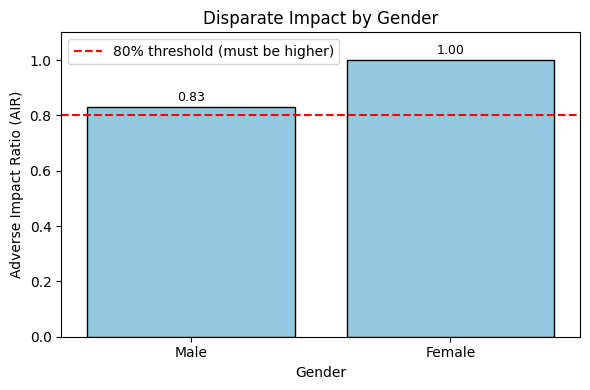

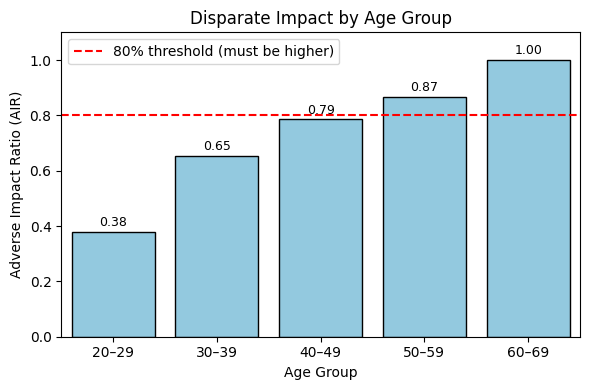

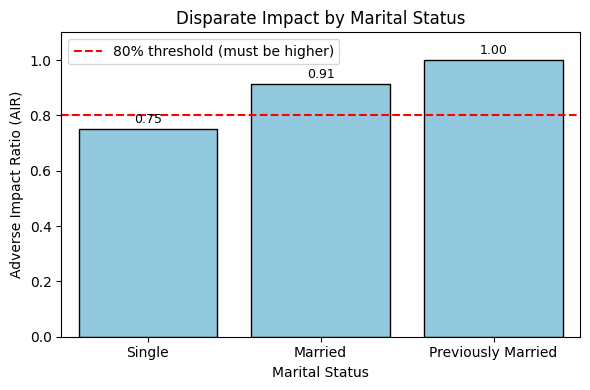

In [231]:
# Plot each fairness dimension
plot_disparate_impact(di_gender, "Gender", "Gender")
plot_disparate_impact(di_age, "Age Group", "Age Group")
plot_disparate_impact(di_marital, "Marital Status", "Marital Status")

These results indicate that gender-based and marital-status-based differences are relatively small and plausibly explained by legitimate business factors such as household income or dependents. However, age groups exhibit substantial variation, with younger applicants (particularly ages 20–39) having much lower favorable rates. Note that some of these rates are exaggerated due to the low threshold we set, which is also why we are considering this model to be a 'flag' not a 'decision-maker.'

The lower favorable rates for younger applicants stem primarily from their higher observed default rates, not from direct inclusion of age in the model, which was excluded entirely. Below is the actual default rates by age group to prove this:

<Axes: title={'center': 'Actual Default Rate by Age Group'}, xlabel='Age Group', ylabel='Default Rate'>

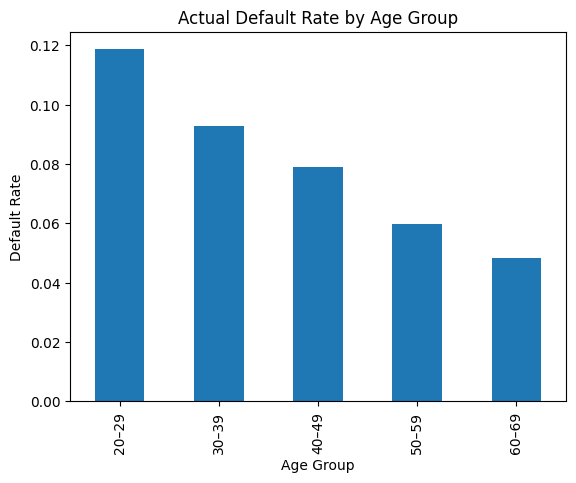

In [234]:
apps_holdout_strat.groupby("AGE_GROUP")["TARGET"].mean().plot(
    kind="bar", title="Actual Default Rate by Age Group",
    ylabel="Default Rate", xlabel="Age Group"
)

This bar chart confirms that younger applicants genuinely default more often, which justifies some degree of adverse treatment under 'business_necessity'. The model’s behavior reflects genuine risk differences rather than bias.

Overall, we meet legal fairness expectations, but in order to maintain ethical/reputational standards, we should implement consistent fairness monintoring in practice to ensure that these flags do not result in unjustified bias when making real decisions. 

# Threshold Tuning Part 2

This time, instead of classifying applicants as "good" and "risky", we will make it a 3-way decision policy to make the application process more efficient, accurate, and equitable:

- **Approve** 
    - business reason: applicants that the model is very confident will *not* default, do not need to be reviewed further
    - precision for non-default must be greater than a pre-determined rate (>0.95?)
- **Deny**
    - business reason: avoid costly defaults. these applicants are deemed very risky and we do not need to review further. 
    - precision greater than pre-determined rate. must be very confident because approving a risky applicant has a huge cost
- **Review**
    - applicants that are between the approve and deny thresholds are sent for further human review
    - should be a sufficiently small percentage of applications (15-30%?) so we can propose an efficient and helpful solution

This list is in order of priority considering approving a risky applicant has the biggest risk. 

Overall, we just want to be confident about approval or denial decisions, while also not dumping a long list of applicants onto our client, which would defeat the purpose of automation.

A function to calculate our metrics of interest for predicted probs and a given threshold pair:

In [280]:
def thresh_pair_metrics(y_true, y_prob, t_low, t_high):

    # make decisions (0=Approve, Deny=1, Review=2)
    decision = np.where(y_prob <= t_low, 0, np.where(y_prob >= t_high, 1, -1)) 

    # compute some metrics for each class
    metrics = {}
    for name, k in [("approve",0), ("review",-1), ("deny",1)]:

        # how many applicants in this group (and %)
        idx = (decision==k)
        n = idx.sum() 
        metrics[f"{name}_n"] = n
        metrics[f"{name}_rate"] = n / len(y_true)

        # default rate in this group
        metrics[f"{name}_default_rate"] = y_true[idx].mean() if n else np.nan

    # how often approved loans did not default (precision, high=good)
    metrics["approve_nondefault_precision"] = 1 - metrics["approve_default_rate"]  

    # how often denied loans did default (precision, high=good)
    metrics["deny_default_precision"] = metrics["deny_default_rate"]    

    # recall of defaults caught by deny
    pos = (y_true==1)
    metrics["deny_default_recall"] = ((decision==1) & pos).sum() / max(pos.sum(),1)

    return metrics

A function to evaluate a bunch of different threshold pairs:

In [285]:
def search_thresholds(y_true, y_prob, target_approve_prec=0.95, target_deny_prec=0.45, target_review_rate=0.25):

    # loop through possible threshold pairs
    rows = []
    for t_low in np.linspace(0.05, 0.40, 71):      # approve threshold grid
        for t_high in np.linspace(0.50, 0.90, 81):  # deny threshold grid
            if t_low >= t_high: 
                continue

            # get metrics for this threshold pair
            metrics = thresh_pair_metrics(y_true, y_prob, t_low, t_high)

            # check if meets each target constraint
            approve_ok = (metrics["approve_nondefault_precision"] >= target_approve_prec)
            deny_ok = (metrics["deny_default_precision"] >= target_deny_prec)
            review_ok = (metrics["review_rate"] <= target_review_rate)

            # if all are good, compute a overall score of how good it did (kind of arbitrary)
            ## weight good denials heaviest because want to avoid approving bad loans
            if approve_ok and deny_ok and review_ok:
                rows.append({"t_low":t_low, "t_high":t_high, **metrics})
                
    return pd.DataFrame(rows)

*Pick thresholds based on CV OOF probabilities only, and then we can evaluate on holdout. Prevents data leakage*

We will iteratively make the target precisions more strict depending on how many eligible thresholds there are. Which targets we make strict will mostly depend on order of priority (described above) and what we see in the data, as in what seems to have more wiggle-room. This is how we will select the final threshold pairs

In [325]:
thresh_pair_results = search_thresholds(preds.y_true, preds.y_prob, 
                                        target_approve_prec=0.95, 
                                        target_deny_prec=0.5, 
                                        target_review_rate=0.22)

In [328]:
thresh_pair_results[thresh_pair_results.deny_rate > 0.01]

,t_low,t_high,approve_n,approve_rate,approve_default_rate,review_n,review_rate,review_default_rate,deny_n,deny_rate,deny_default_rate,approve_nondefault_precision,deny_default_precision,deny_default_recall
0,0.4,0.795,190329,0.774397,0.042668,52838,0.214984,0.197017,2610,0.010619,0.503065,0.957332,0.503065,0.066166


Final Thresholds:

- **Low:** 0.4
- **High:** 0.8

Try on holdout set:

In [332]:
thresh_pair_metrics(apps_holdout_strat.TARGET, apps_holdout_strat.y_prob, 0.4, 0.8)

{'approve_n': 47540,
 'approve_rate': 0.7737252412805364,
 'approve_default_rate': 0.04192259150189314,
 'review_n': 13288,
 'review_rate': 0.21626548182868674,
 'review_default_rate': 0.199578567128236,
 'deny_n': 615,
 'deny_rate': 0.010009276890776818,
 'deny_default_rate': 0.5121951219512195,
 'approve_nondefault_precision': 0.9580774084981069,
 'deny_default_precision': 0.5121951219512195,
 'deny_default_recall': 0.06350806451612903}

**Info summary for report:**

The objective of our loan approval model is to minimize costly defaults while maintaining fairness and operational efficiency. Since different types of errors have vastly different business costs, our three-way decision policy is built around the following priorities (in order of importance):

| **Goal**                             | **Description**                                              | **Business Cost**                                                                                 |
| :----------------------------------- | :----------------------------------------------------------- | :------------------------------------------------------------------------------------------------ |
| **1. Minimize Defaulters**           | Avoid approving applicants who are likely to default.        | Defaults are the most expensive outcome, leading to direct financial losses. |
| **2. Minimize Missed Opportunities** | Avoid denying applicants who would have successfully repaid. | Opportunity cost from lost potential revenue and reputation from making overly conservative decisions.                   |
| **3. Minimize Review Volume**        | Keep the manual review workload manageable.                  | Human review adds operational cost and delays but is less costly than defaults.                   |


Instead of classifying all applicants as “good” or “bad,” we define a three-way decision policy based on predicted default probability:

| Category    | Risk Range   | Decision Logic                                                   | Business Interpretation                |
| :---------- | :----------- | :--------------------------------------------------------------- | :------------------------------------- |
| **Approve** | ≤ 0.40       | Approve with no further review. These are the safest applicants. | Low risk, minimal cost.                |
| **Review**  | (0.40, 0.80) | Flag for further manual review.                             | Uncertain. Balances risk and fairness. |
| **Deny**    | ≥ 0.80       | Automatically deny due to high risk of default.            | High risk, large potential loss.       |

This framework ensures that safe applicants are approved quickly with confidence, high-risk applicants are denied automatically, and uncertain cases recieve human oversight to promote fairness and legal compliance without too much operational cost. 

In evaluating our thresholds on an unseen holdout set, we observed the following results:

| Decision    | Role                                                                                    | Share of Applicants | Default Rate |
| :---------- | :-------------------------------------------------------------------------------------- | :-----------------: | :----------: |
| **Approve** | Approve low-risk applicants confidently.                                                |      **77.4%**      |   **4.2%**   |
| **Review**  | Send uncertain cases to human review where judgment can add value and promote fairness. |        21.6%        |     19.9%    |
| **Deny**    | Automatically reject high-risk applicants that are likely to default.                   |       **1.0%**      |   **51.2%**  |


These results align with our goal of an effective, business-focused loan approval model. We prioritize financial protection by ensuring that approved applicants rarely default (<5% of the time) while keeping the review workload manageable (21.6%) and limiting automatic denials to 1% of the most high-risk cases. Within this review group, roughly 1 in 5 applicants are expected to default, meaning the review process is targeting the group where additional context can be most valuable. These are not clear approvals or denials, so human judgment here can help maximize opportunity without meaningfully increasing risk.

From a fairness perspective, this approach is more equitable than a strict yes/no cutoff. Instead of automatically denying all borderline applicants, the model defers uncertain decisions to manual review, giving those applicants another chance to be evaluated with context that models can't capture. To preserve fairness, Home Credit's reviewers should use consistent, transparaent guidelines whiel considering factors the model cannot measure in order to not simply replicate predictions. The balance between automation and human context ensures both profitability and fairness. 

# Fairness Part Two

Evaluating fairness similarly to before, but with the double threshold policy now. 

This time there are some nuanced questions to consider as we take a similar approach:

- Are certain groups overrepresented in the review category instead of being denied automatically?
    - this would suggest *improved* fairness because they get reconsidered rather than just rejecting them like we did before
    - ex: younger applicants were rejected more before. if they get reviewed more now, but rejected at a similar rate to other age groups, this is more fair. they previously got rejected most likely because of a lack of credit history. but now they can get reviewed for other context that the model doesn't have
- Is any group still being denied at a disproportionate rate compared to their actual risk?
    - this would mean we still have disparate impact. however, if we notice they are getting rejected a rate that is related to that groups actual default rate, then we can argue business justification, especially because our models are technically unaware of the groups directly

Prep data:

In [340]:
# classify as approve, review, or deny
t_low, t_high = 0.4, 0.8
df = apps_holdout_strat.copy()
df["decision"] = np.where(df["y_prob"] <= t_low, 0,
                   np.where(df["y_prob"] >= t_high, 1, -1))
df["decision_label"] = np.where(df["decision"]==0, "Approve",
                         np.where(df["decision"]==1, "Deny", "Review"))

# make gender a readable column
if "CODE_GENDER_M" in df.columns:
    df["GENDER"] = np.where(df["CODE_GENDER_M"].astype(bool), "Male", "Female")
elif "CODE_GENDER" in df.columns:
    df["GENDER"] = np.where(df["CODE_GENDER"].astype(str).str.upper().str.startswith("M"), "Male", "Female")
else:
    raise ValueError("Need CODE_GENDER_M or CODE_GENDER to build GENDER.")

# bin ages by decades
bins   = [20,30,40,50,60,70]
labels = ["20–29","30–39","40–49","50–59","60–69"]
df['AGE_GROUP'] = pd.cut(df['AGE_INT'], 
                                         bins=bins, labels=labels, right=False)

# convert marital status to readable label
status_cols = [c for c in df.columns if c.startswith("NAME_FAMILY_STATUS_")]
def get_status(row):
    for c in status_cols:
        if row[c] == 1:
            return c.replace("NAME_FAMILY_STATUS_", "")
    return "Married"
df["MARITAL_STATUS"] = df.apply(get_status, axis=1)

Function for making tables:

In [341]:
def group_table(df, group_col, y_col="TARGET"):
    g = df.groupby(group_col)
    out = pd.DataFrame({
        "n": g.size(),
        "Approve %": g.apply(lambda x: (x["decision"]==0).mean()*100),
        "Review %":  g.apply(lambda x: (x["decision"]==-1).mean()*100),
        "Deny %":    g.apply(lambda x: (x["decision"]==1).mean()*100),
        "Actual Default %": g[y_col].mean()*100
    }).sort_index()
    return out.round({"Approve %":1,"Review %":1,"Deny %":1,"Actual Default %":1})

Make a table for each protected group:

In [342]:
group_table(df, "GENDER")

,n,Approve %,Review %,Deny %,Actual Default %
GENDER,,,,,
Female,40608,79.7,19.4,0.9,7.0
Male,20835,72.9,25.9,1.2,10.1


In [343]:
group_table(df, "AGE_GROUP")

,n,Approve %,Review %,Deny %,Actual Default %
AGE_GROUP,,,,,
20–29,9083,57.8,39.8,2.4,11.9
30–39,16277,73.8,24.9,1.3,9.3
40–49,15236,80.2,19.0,0.7,7.9
50–59,13624,84.6,14.9,0.5,6.0
60–69,7223,90.3,9.6,0.2,4.8


In [344]:
group_table(df, "MARITAL_STATUS")

,n,Approve %,Review %,Deny %,Actual Default %
MARITAL_STATUS,,,,,
Married,45224,77.9,21.1,1.0,7.9
Previously Married,7190,82.6,16.8,0.7,6.9
Single,9029,70.7,27.9,1.4,9.8


Evidence of default rate by age:

<Axes: title={'center': 'Actual Default Rate by Age Group'}, xlabel='Age Group', ylabel='Default Rate'>

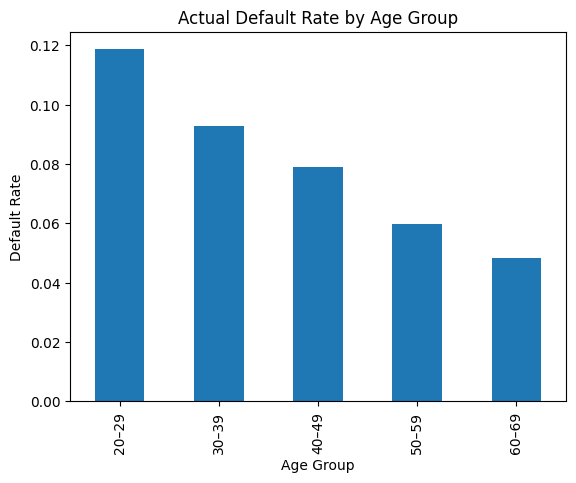

In [355]:
df.groupby("AGE_GROUP")["TARGET"].mean().plot(
    kind="bar", title="Actual Default Rate by Age Group",
    ylabel="Default Rate", xlabel="Age Group"
)

**Summary of info for report:**

- Men have lower approval rates (72.9% vs. 79.7% for women), but the difference is relatively proportional to higher observed default rates (10.1% vs. 7.0%). 
- Single applicants are also reviewed more frequently (27.9%) but follow the same risk trend.
- Younger applicants (20–29) show the lowest approval rate (57.8%) and highest default rate (11.9%), but nearly 40% are reviewed instead of rejected automatically.

Our fairness assessment evaluated both disparate treatment (explicit use of protected attributes) and disparate impact (unequal outcomes through correlated proxy attributes). To prevent disparate treatment, all legally protected features—such as gender, age, and marital status—were removed from model training. This ensures compliance with the Equal Credit Opportunity Act (ECOA) and minimizes legal exposure. For disparate impact, we confirmed that approval rates across demographic groups generally align with actual default risks, providing business justification.

Ethically, our three-way decision framework (Approve/Review/Deny) promotes fairness and reputational integrity by allowing human judgment in uncertain cases that may require additional context. For example, younger applicants who tend to have limited credit history are reviewed rather than denied automatically, ensuring they retain access to credit opportunities. Verified through thorough evaluation, this approach balances performance and fairness to a high degree.

# Extra Stuff

Investigating some stuff we might want to include in the report.

### Feature importance

In [ ]:
import shap
from scipy.stats import spearmanr
X_eval = X_test.copy()  

# ensure numeric dtypes
for c in X_eval.columns:
    if X_eval[c].dtype == 'bool':
        X_eval[c] = X_eval[c].astype(float)
    elif X_eval[c].dtype == 'object':
        X_eval[c] = pd.to_numeric(X_eval[c], errors='coerce')
X_eval = X_eval.fillna(0.0).astype(float)

# compute SHAP values
explainer = shap.Explainer(model, X_eval, feature_names=X_eval.columns)
sv = explainer(X_eval, check_additivity=False)

# directionality table
sv_mat = sv.values
rows = []
for j, c in enumerate(X_eval.columns):
    vals = sv_mat[:, j]
    rho, _ = spearmanr(X_eval[c], vals)
    rows.append({
        "feature": c,
        "mean_shap": np.mean(vals),
        "mean_abs_shap": np.mean(np.abs(vals)),
        "pct_positive_shap": (vals > 0).mean(),
        "spearman(feature, shap)": rho
    })
dir_df = pd.DataFrame(rows).sort_values("mean_abs_shap", ascending=False).round(4)


100%|===================| 61379/61443 [13:30<00:00]        /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


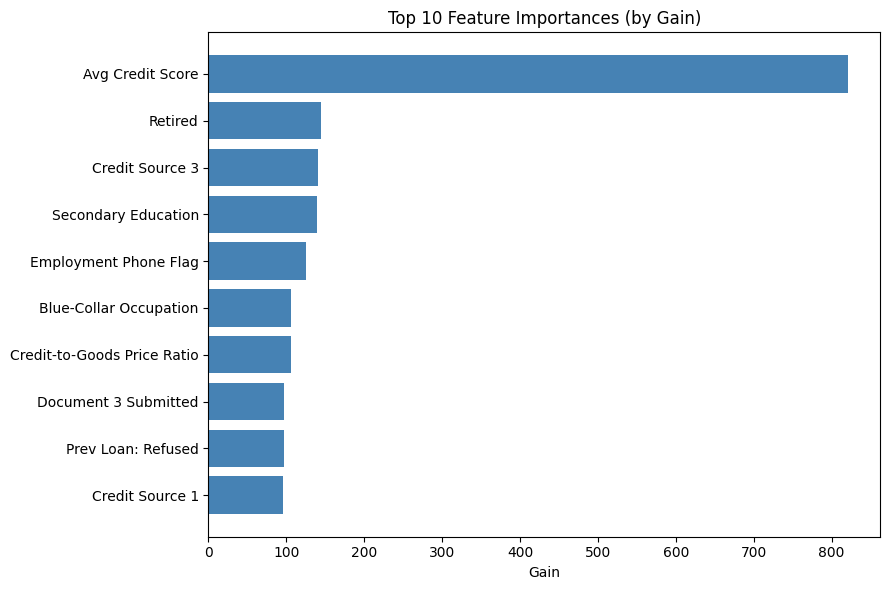

In [408]:
import matplotlib.pyplot as plt
import pandas as pd

# get feature importances
imp = model.get_booster().get_score(importance_type='gain') 
imp_df = (pd.Series(imp, name='gain')
            .sort_values(ascending=False)
            .head(10)
            .round(4)                    
            .rename_axis('feature')
            .reset_index())

# manually map feature names to more readable labels
name_map = {
    'EXT_SOURCE_MEAN': 'Avg Credit Score',
    'NAME_INCOME_TYPE_Retired': 'Retired',
    'EXT_SOURCE_3': 'Credit Source 3',
    'NAME_EDUCATION_TYPE_Secondary': 'Secondary Education',
    'FLAG_EMP_PHONE': 'Employment Phone Flag',
    'OCCUPATION_TYPE_Blue-collar': 'Blue-Collar Occupation',
    'credit_goods_price_ratio': 'Credit-to-Goods Price Ratio',
    'FLAG_DOCUMENT_3': 'Document 3 Submitted',
    'prev_last_decision_status_internal_Refused': 'Prev Loan: Refused',
    'EXT_SOURCE_1': 'Credit Source 1',
    'inst_prop_late_payments_internal': 'Late Payment Ratio (Internal)',
    'installment_payment_ratio_1000_mean_mean_internal': 'Installment Payment Ratio (Internal)',
    'num_pos_loans_internal': '# Positive Loans (Internal)',
    'avg_credit_debt_ratio_external': 'Avg Credit-to-Debt Ratio (External)',
    'NAME_CONTRACT_TYPE_Revolving loans': 'Contract Type: Revolving Loan'
}

imp_df['feature_clean'] = imp_df['feature'].map(name_map).fillna(imp_df['feature'])

# plot
plt.figure(figsize=(9, 6))
plt.barh(imp_df['feature_clean'][::-1], imp_df['gain'][::-1], color='steelblue')
plt.xlabel('Gain')
plt.title('Top 10 Feature Importances (by Gain)')
plt.tight_layout()
plt.show()


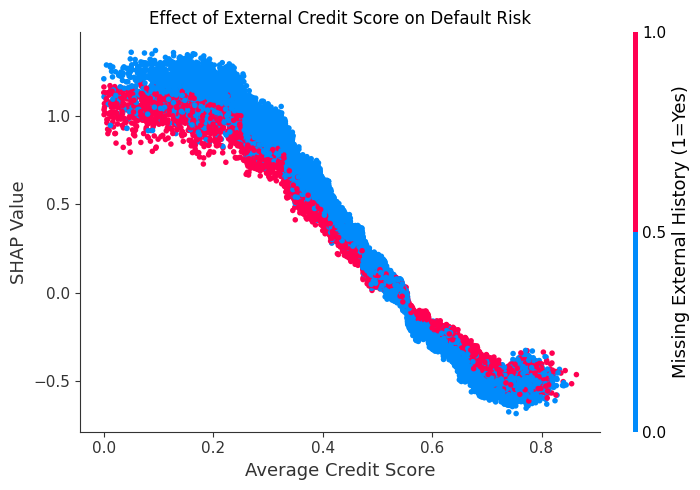

In [405]:
# readable label mapping just for this plot
label_map = {
    'EXT_SOURCE_MEAN': 'Average Credit Score'
}
X_plot = X_eval.rename(columns={
    "no_bureau_history_external": "Missing External History (1=Yes)"
})

# make shap dependence plot
shap.dependence_plot(
    'EXT_SOURCE_MEAN',
    sv.values,
    X_plot,
    feature_names=X_plot.columns,
    interaction_index='Missing External History (1=Yes)',
    show=False
)
plt.xlabel(label_map.get('EXT_SOURCE_MEAN', 'EXT_SOURCE_MEAN'))
plt.ylabel(f"SHAP Value")
plt.title("Effect of External Credit Score on Default Risk", fontsize=12)
plt.tight_layout()
plt.show()


We found that Average External Credit Score dominates model gain (feature importance plot above), meaning the model relies heavily on this metric to separate low and high-risk applicants. Additionally, this metric interacted most strongly with the presence indicator of external loan history in the model. The SHAP dependence plot confirms that higher external credit scores sharply decrease default risk (negative SHAP values), while applicants with no bureau history (colored in blue) tend to have higher risk even at similar credit scores. This suggests that limited credit information adds uncertainty.

### Classification

Target class distribution (for intro of report):

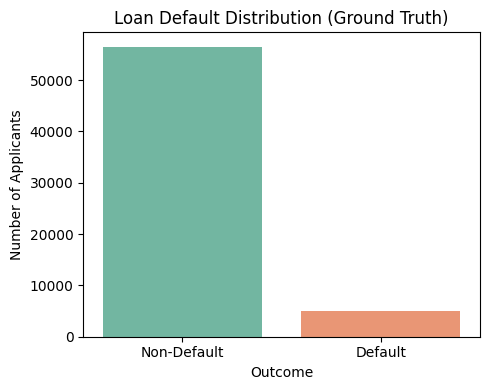

In [370]:
plt.figure(figsize=(5,4))
sns.countplot(x=df["TARGET"].map({0: "Non-Default", 1: "Default"}), palette="Set2")
plt.title("Loan Default Distribution (Ground Truth)")
plt.xlabel("Outcome")
plt.ylabel("Number of Applicants")
plt.tight_layout()
plt.show()

Three-way decision breakdown:

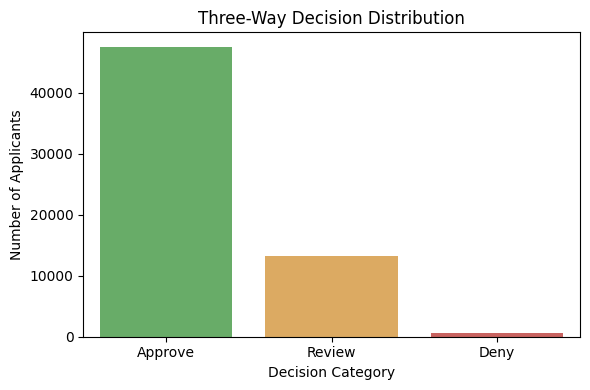

In [371]:
plt.figure(figsize=(6,4))
order = ["Approve", "Review", "Deny"]
sns.countplot(
    x=df["decision"].map({0:"Approve", -1:"Review", 1:"Deny"}), 
    order=order, 
    palette=["#5cb85c","#f0ad4e","#d9534f"]
)
plt.title("Three-Way Decision Distribution")
plt.xlabel("Decision Category")
plt.ylabel("Number of Applicants")
plt.tight_layout()
plt.show()

Default rates per decision category:

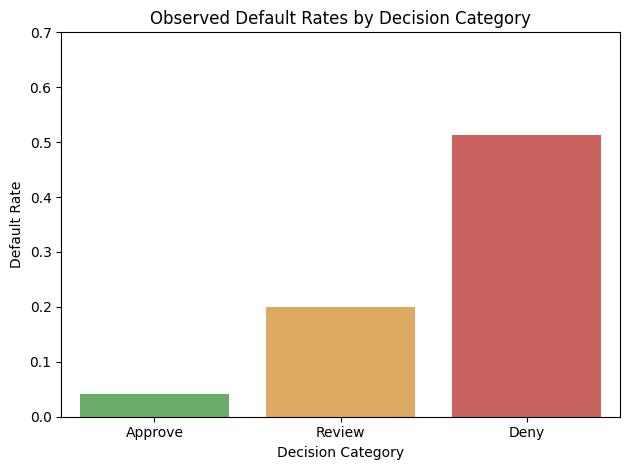

In [373]:
default_rates = (
    df.groupby("decision")["TARGET"]
      .mean()
      .rename({0:"Approve", -1:"Review", 1:"Deny"})
      .reset_index(name="Default Rate")
)

sns.barplot(
    data=default_rates,
    x="decision", y="Default Rate",
    order=["Approve","Review","Deny"],
    palette=["#5cb85c","#f0ad4e","#d9534f"]
)
plt.title("Observed Default Rates by Decision Category")
plt.ylabel("Default Rate")
plt.xlabel("Decision Category")
plt.ylim(0,0.7)
plt.tight_layout()
plt.show()


# Eyeball Dev Set Creation

Eve though we are doing the three-way policy decisions, we will stick with Approve or Deny for errors because that is what our response variable looks like. 

Get set of errors:

In [400]:
y_true = apps_holdout_strat["TARGET"]
y_prob = apps_holdout_strat["y_prob"]
y_pred = apps_holdout_strat["y_pred"]
errors = apps_holdout_strat[y_true != y_pred].copy()
errors.shape

(28307, 227)

Take a random sample with balanced error types:

In [401]:
false_pos = errors[(errors["TARGET"] == 0) & (errors["y_pred"] == 1)]
false_neg = errors[(errors["TARGET"] == 1) & (errors["y_pred"] == 0)]
eyeball_balanced = pd.concat([
    false_pos.sample(n=50, random_state=42),
    false_neg.sample(n=50, random_state=43)
])

Keep a smaller subset of the 200+ features so its more manageable to eyeball:

In [402]:
cols_to_keep = [
    "SK_ID_CURR",
    "TARGET",
    "y_pred",
    "y_prob",

    # main risk indicators
    "EXT_SOURCE_MEAN",
    "DAYS_EMPLOYED",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_INCOME_TOTAL",

    # important categorical stuff
    "NAME_INCOME_TYPE_Retired",
    "NAME_INCOME_TYPE_Not working",
    "NAME_INCOME_TYPE_Self-employed",
    "NAME_EDUCATION_TYPE_Low",
    "NAME_EDUCATION_TYPE_Secondary",
    "OWN_CAR_AGE",

    # missing data flags (uncertainty)
    "no_bureau_history_external",
    "no_internal_history"
]

# add type of error
eyeball_subset = eyeball_balanced[cols_to_keep].copy()
eyeball_subset["error_type"] = np.where(
    (eyeball_subset["TARGET"] == 0) & (eyeball_subset["y_pred"] == 1),
    "False Positive",
    "False Negative"
)

Split into two parts for assignement and send to .xlsx file:

In [403]:
eyeball_subset = eyeball_subset.sample(frac=1, random_state=42).reset_index(drop=True)
eyeball_subset["Part"] = np.where(np.arange(len(eyeball_subset)) < len(eyeball_subset)/2, 1, 2)

# add columns that we are supposed to fill in for assignment
eyeball_subset["possible_causes"] = ""
eyeball_subset["notes"] = ""

# send to xlsx for manual review
eyeball_subset.to_excel("eyeball/eyeball_errors_xgb.xlsx", index=False)